# Курсовой проект

1. [Импорт библиотек](#import)
2. [Загрузка данных](#load_data) <br>
    2.1. [Номинативные переменные](#cat_features) <br>
    2.2. [Количественные переменные](#num_features) <br>
3. [Полезные функции для обработки данных](#functions)
4. [Подготовка данных для анализа](#preparation)
5. [Построение модели](#model)
6. [Сохранение результатов](#results)

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств.

## Импорт библиотек <a class="anchor" id="import"></a>

In [74]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import shapiro
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import catboost as catb

%matplotlib inline

In [75]:
import warnings
warnings.simplefilter('ignore')

## Загрузка данных <a class="anchor" id="load_data"></a>

In [76]:
TEST_PATH = 'course_project_test.csv'
TRAIN_PATH = 'course_project_train.csv'

df = pd.read_csv(TRAIN_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - оценка кредитоспособности индивида 
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Видно, что для некоторых признаков присутствуют пропущенные значения. Необходимо проанализировать пропуски и определить использовать ли данные признаки в анализе. В случае положительного ответа нужно разработать механизм заполнения пропусков.

Проведем первичный анализ данных. Это позволит лучше понять их структуру и потенциально выявить зависимости, которые можно будет использовать.

In [78]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Стоит отметить, что присутствует определенная несбалансированность классов целевой переменной.

## Номинативные переменные <a class="anchor" id="cat_features"></a>

#### Home Ownership

In [79]:
df['Home Ownership'].value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

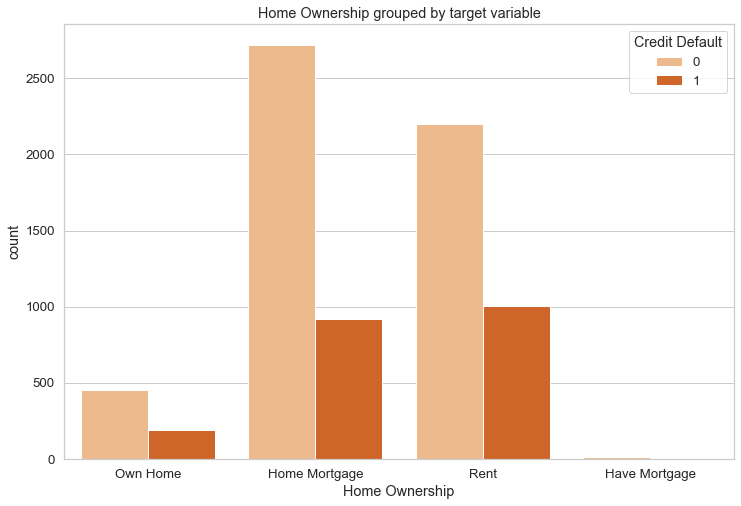

In [80]:
plt.figure(figsize=(12, 8))
sns.set(font_scale=1.2, style='whitegrid')
sns.countplot(x='Home Ownership', hue='Credit Default', palette='Oranges', data=df)
plt.title('Home Ownership grouped by target variable')
plt.show()

Можно отметить два момента: 
1) Присутствует небольшое количество значений **Have Mortgage**. Скорее всего это указывает на ошибки при заполнении, а корректное значение **Home Mortgage**. С другой стороны этих значений ничтожно мало, поэтому маловероятно, чтобы они оказали влияние на результаты нашего исследования; <br>
2) Дефолт/просрочка более вероятны в случае индивидов, арендующих жилье.

#### Tax Liens

In [81]:
df['Tax Liens'].value_counts()

0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64

Данный признак, на мой взгляд, вряд ли может быть полезен при классификации клиентов. Для более 98% записей он имеет одно значение - _0_.

#### Years in current job

In [82]:
df['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [83]:
df['Years in current job'].isna().value_counts()

False    7129
True      371
Name: Years in current job, dtype: int64

На мой взгляд, наиболее разумным будет заполнить пропуски наиболее часто встречающимся значением признака.

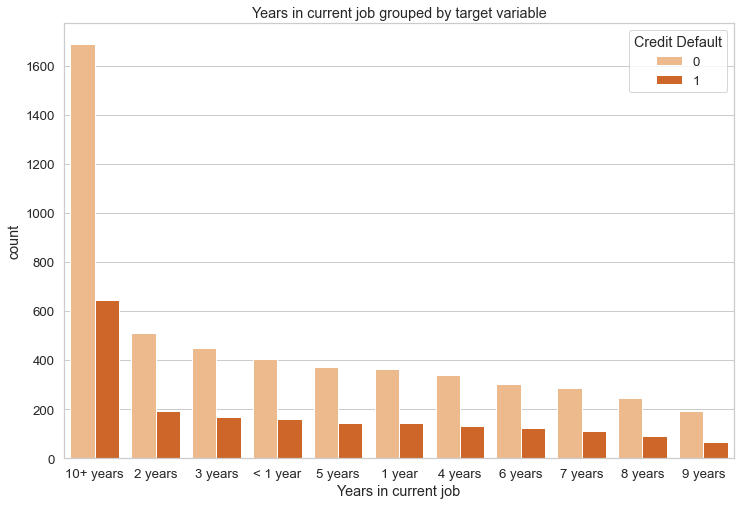

In [84]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Years in current job', hue='Credit Default', 
              order=df['Years in current job'].value_counts().index, palette='Oranges', data=df)
plt.title('Years in current job grouped by target variable')
plt.show()

График распределения данной переменной в зависимости от целевой переменной указывает на то, что она не дает возможности хорошо идентифицировать индивидов с дефолтом/просрочкой. А значит она тоже вряд ли будет полезна в анализе.

#### Number of Credit Problems

In [85]:
df['Number of Credit Problems'].value_counts()

0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64

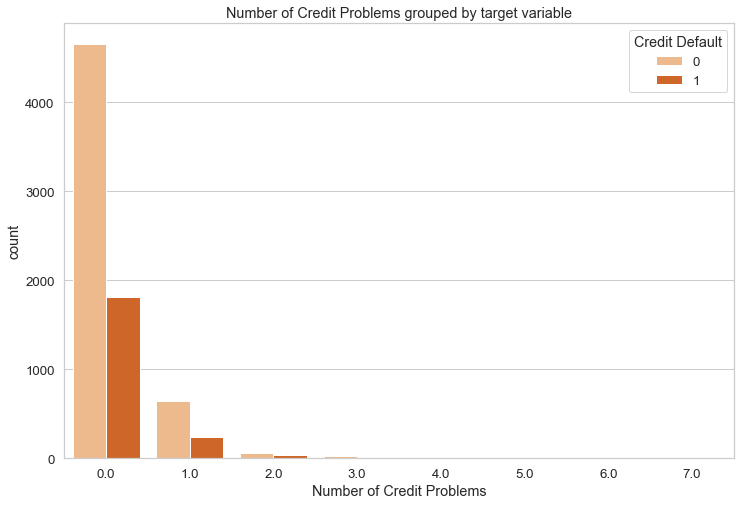

In [86]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Number of Credit Problems', hue='Credit Default', palette='Oranges', data=df)
sns.set(font_scale=1.2, style='whitegrid')
plt.legend(title='Credit Default', loc='upper right')
plt.title('Number of Credit Problems grouped by target variable')
plt.show()

Ситуация очень похожа на рассмотренный ранее признак **Tax Liens**, с той лишь разницей, что здесь подавляющее большинство значений распределено между двумя вариантами. Однако опять же судя по графику пропорциональность распределения целевой переменной сохраняется, а значит снова можно ожидать, что данный признак будет не очень полезен в дальнейшем.

#### Bankruptcies

In [87]:
df['Bankruptcies'].value_counts()

0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64

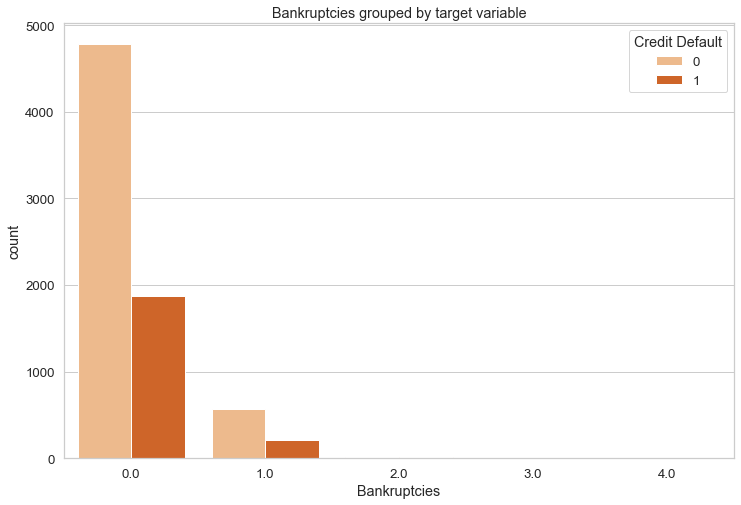

In [88]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Bankruptcies', hue='Credit Default', palette='Oranges',
              data=df)
plt.title('Bankruptcies grouped by target variable')
plt.show()

Ситуация с данным признаком полностью аналогична рассмотренной ранее с признаком **Number of Credit Problems**. Более того их графики очень сильно похожи. Это указывает на то, что при построении модели достаточно будет использовать один из данных признаков. Дополнительная информация от второго в паре будет минимальна.

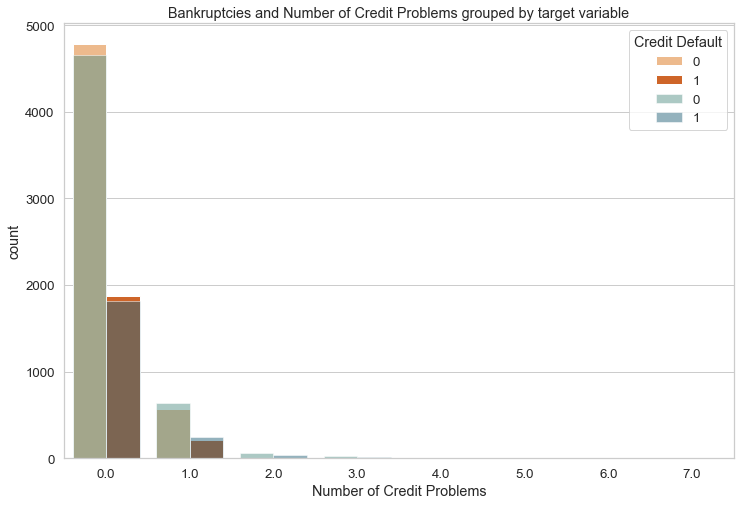

In [89]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Bankruptcies', hue='Credit Default', palette='Oranges',
              data=df)
sns.countplot(x='Number of Credit Problems', hue='Credit Default', palette='crest', alpha=.5, 
              data=df)
plt.title('Bankruptcies and Number of Credit Problems grouped by target variable')
plt.legend(title='Credit Default', loc='upper right')
plt.show()

#### Purpose

In [90]:
df['Purpose'].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

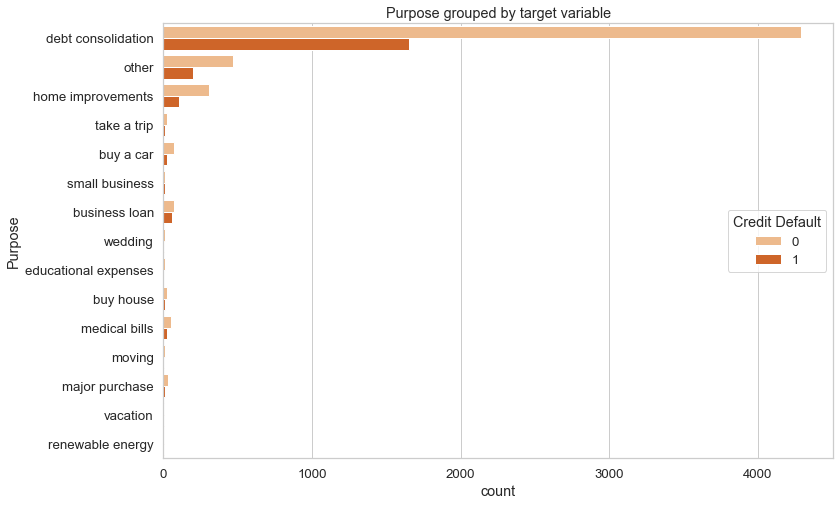

In [91]:
plt.figure(figsize=(12, 8))
sns.countplot(y='Purpose', hue='Credit Default', palette='Oranges',data=df)
plt.title('Purpose grouped by target variable')
plt.show()

#### Term

In [92]:
df['Term'].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

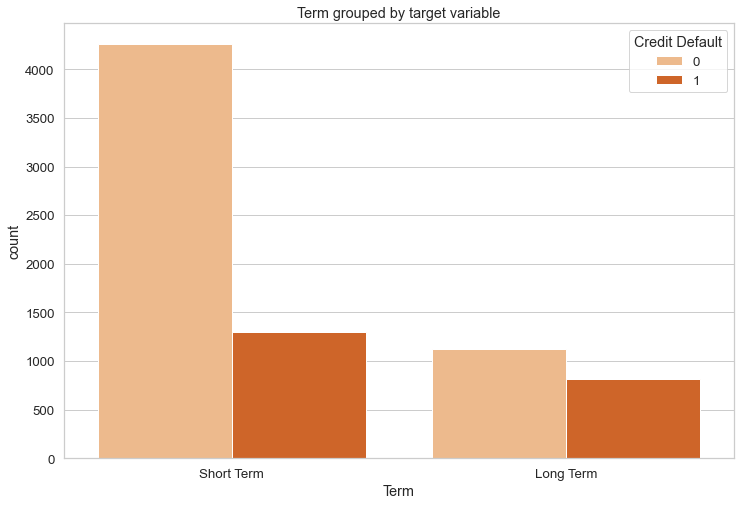

In [93]:
plt.figure(figsize=(12, 8))
sns.countplot(x='Term', hue='Credit Default', palette='Oranges', data=df)
plt.title('Term grouped by target variable')
plt.show()

Похоже, что доля дефолтов при долгосрочных кредитах больше. Этот признак скорее всего будет полезен при классификации.

## Количественные переменные <a class="anchor" id="num_features"></a>

#### Annual Income

In [94]:
df['Annual Income'].describe()

count    5.943000e+03
mean     1.366392e+06
std      8.453392e+05
min      1.645970e+05
25%      8.443410e+05
50%      1.168386e+06
75%      1.640137e+06
max      1.014934e+07
Name: Annual Income, dtype: float64

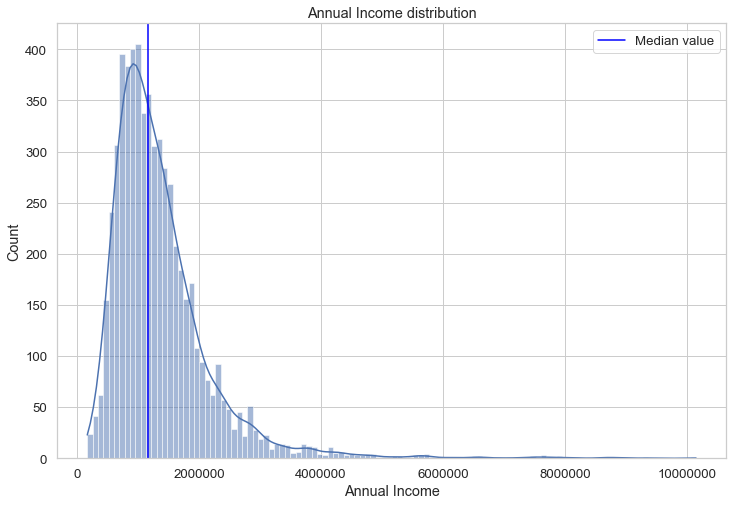

In [95]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df['Annual Income'], kde=True)
plt.axvline(df['Annual Income'].median(), color='blue', label='Median value')
plt.title('Annual Income distribution')
plt.legend()
plt.show()

Посмотрим на распределение признака в зависимости от целевой переменной.

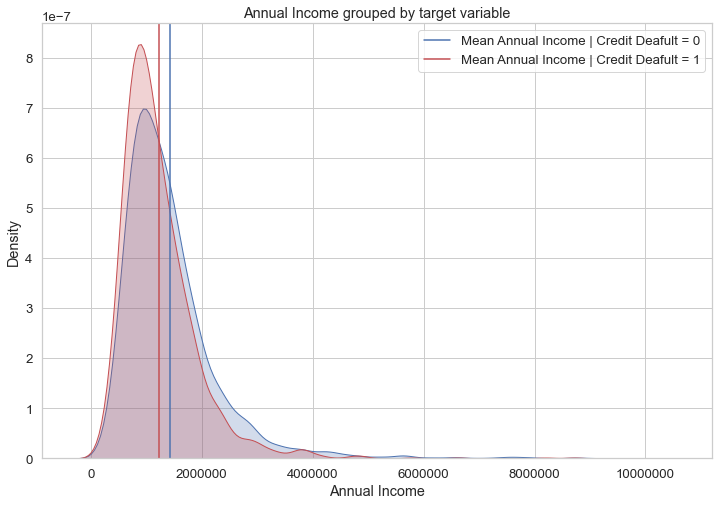

In [96]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(df.loc[df['Credit Default'] == 0, 'Annual Income'], shade=True)
plt.axvline(df.loc[df['Credit Default'] == 0, 'Annual Income'].mean(), color='b', 
            label='Mean Annual Income | Credit Deafult = 0')
sns.kdeplot(df.loc[df['Credit Default'] == 1, 'Annual Income'], shade=True, color='r')
plt.axvline(df.loc[df['Credit Default'] == 1, 'Annual Income'].mean(), color='r', 
            label='Mean Annual Income | Credit Deafult = 1')
plt.title('Annual Income grouped by target variable')
plt.legend()
plt.show()

Похоже что две группы, полученные в результате разбиения признака **Annual Income** по целевой переменной, имеют различные распределения. Это может помочь при построение модели, т.к. это будет означать, что между признаком **Annual Income** и целевой переменной, возможно, существует некоторая функциональная зависимость.

**Гипотеза** 
* Нулевая гипотеза: средние значения в двух полученных выборках равны
* Альтернативная гипотеза: средние значения в двух выборках различаются
* Критерий: критерий Стьюдента (t-тест) и его аналоги
* Уровень значимости $\normalsize \alpha$: 0.05
* Критическая область: двухсторонняя

Что бы проверить данную гипотезу сравним две выборки из рассматриваемых групп на предмет равенства средних значений.

Распределение признака **Annual Income** не похоже на нормальное, однако для полной уверенности проверим его с помощью статистического критерия Шапиро-Уилка.

In [97]:
annual_income_sample = df.loc[~df['Annual Income'].isna(), ['Annual Income', 'Credit Default']].sample(2000)
shapiro(annual_income_sample)

ShapiroResult(statistic=0.7505955100059509, pvalue=0.0)

Значение p-value указывает на то, что гипотеза о нормальности распределения должна быть отвергнута. Поэтому для оценки эквивалентности математических ожиданий в исследуемых выборках воспользуемся критерием Манна-Уитни.

In [98]:
mannwhitneyu(annual_income_sample.loc[annual_income_sample['Credit Default'] == 0, 'Annual Income'], 
             annual_income_sample.loc[annual_income_sample['Credit Default'] == 1, 'Annual Income'])

MannwhitneyuResult(statistic=322001.0, pvalue=4.8331189639849615e-09)

Значение p-value свидетельствует о том, что в данном случае нулевая гипотеза также должна быть отклонена, то есть выборки имеют разное математическое ожидание. Построим также доверительные интервалы для средних значений каждой из двух получившихся групп и сравним результат.

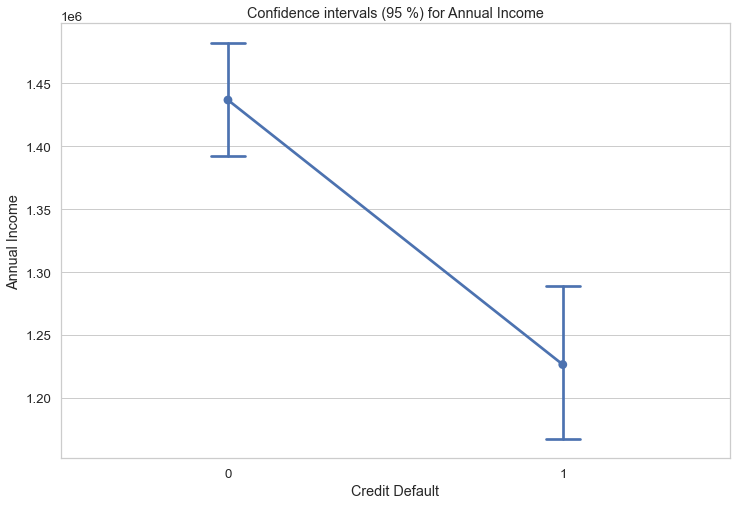

In [99]:
plt.figure(figsize=(12, 8))
sns.pointplot(x='Credit Default', y='Annual Income', data=annual_income_sample, capsize=.1)
plt.title('Confidence intervals (95 %) for Annual Income')
plt.show()

Из графика видно, что интервалы, в которых с 95% вероятностью находятся истинные математические ожидания этих двух групп, не пересекаются. Это подтверждает результаты, полученные с помощью критерия Манна-Уитни.

Это означает, что группы из которых взяты данные выборки, с допускаемой нами вероятностью (95%), имеют различные распределения и этот признак может быть полезен для определения значения целевой переменной.

In [100]:
df['Annual Income'].isna().value_counts()

False    5943
True     1557
Name: Annual Income, dtype: int64

Стоит обратить внимание, что для 20% наблюдений присутствуют пропуски в заполнении данного признака. С учетом характера распределения **Annual Income** предлагаю заменить их медианой.

#### Number of Open Accounts

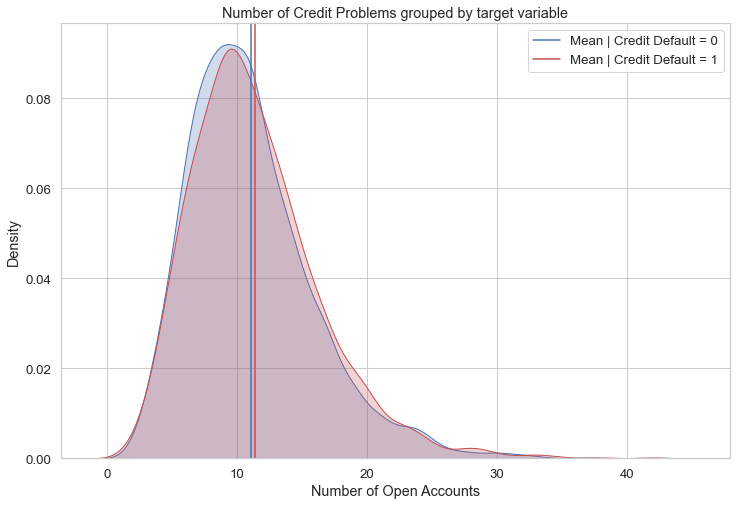

In [101]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(df.loc[df['Credit Default'] == 0, 'Number of Open Accounts'], shade=True)
plt.axvline(df.loc[df['Credit Default'] == 0, 'Number of Open Accounts'].mean(), color='b', 
            label='Mean | Credit Default = 0')
sns.kdeplot(df.loc[df['Credit Default'] == 1, 'Number of Open Accounts'], shade=True, color='r')
plt.axvline(df.loc[df['Credit Default'] == 1, 'Number of Open Accounts'].mean(), color='r', 
            label='Mean | Credit Default = 1')
plt.title('Number of Credit Problems grouped by target variable')
plt.legend()
plt.show()

Видно, что для данного признака распределения двух групп в разрезе целевой переменной очень похожи. Не будет проводить строгой статистической проверки, как для признака выше. Ограничимся анализом доверительных интервалов средних для двух групп.

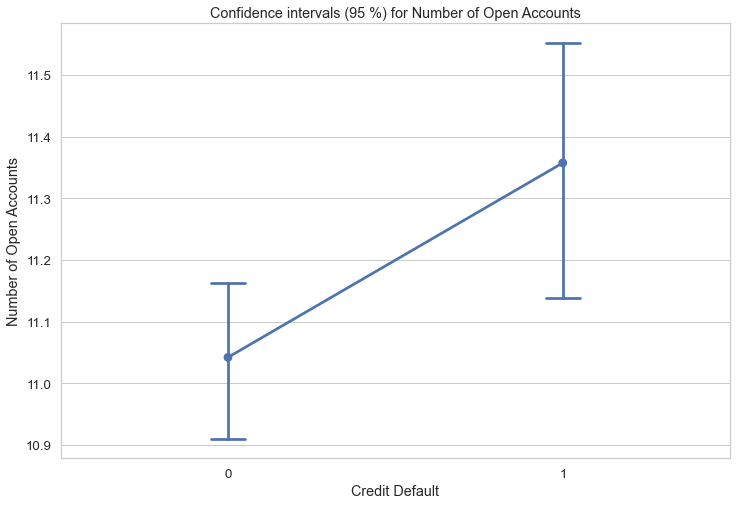

In [102]:
plt.figure(figsize=(12, 8))
sns.pointplot(x='Credit Default', y='Number of Open Accounts', data=df, capsize=.1)
plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

У них есть область пересечения, это позволяет ожидать, что при строгой статистической проверке мы не сможем отвергнуть нулевую гипотезу о равенстве математических ожиданий. То есть можно ожидать, что влияние данного признака на классификацию индивидов будет минимальным.

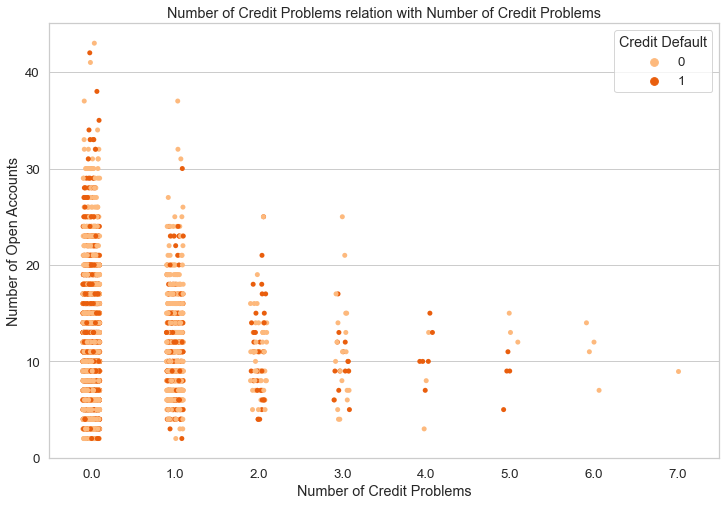

In [103]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='Number of Credit Problems', y='Number of Open Accounts', hue='Credit Default',
              palette='Oranges', data=df)
plt.title('Number of Credit Problems relation with Number of Credit Problems')
plt.show()

Данный график отображает связь между признаками **Number of Open Accounts** и **Number of Credit Problems**. Видно, что количество открытых счетов имеет тенденцию к снижению при увеличении количества проблем с кредитом. Это согласуется с общей логикой. Возможно данное наблюдение пригодится при дальнейшем анализе. Хотя стоит заметить, что выводы о причинно-следственной связи на основе данного графика делать нельзя.<br>
Другое интересное наблюдение, которое можно вынести отсюда, отсутствие просрочек в группе людей с количеством проблем с кредитом более 5. Хотя важно подчеркнуть, что это может быть связано просто с минимальным количеством наблюдений в этих группах.

#### Years of Credit History

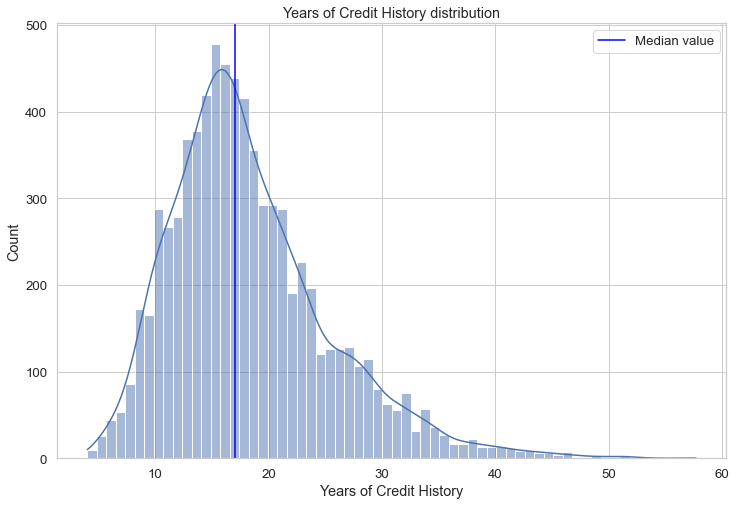

In [104]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df['Years of Credit History'], kde=True)
plt.axvline(df['Years of Credit History'].median(), color='blue', label='Median value')
plt.title('Years of Credit History distribution')
plt.legend()
plt.show()

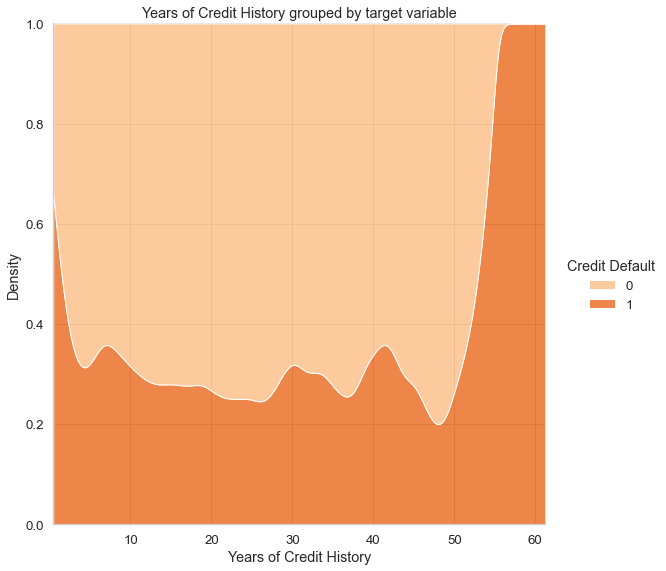

In [105]:
sns.displot(data=df, x='Years of Credit History', hue='Credit Default', kind='kde', 
            height=8, multiple="fill", palette='Oranges')
plt.title('Years of Credit History grouped by target variable')
plt.show()

Вероятность дефолта значительно выше для людей с маленькой или, наоборот, очень большой кредитной историей. Однако это может быть связано просто с небольшим количеством наблюдений для этих значений.

In [106]:
condition1 = df['Years of Credit History'] <= 5
condition2 = df['Years of Credit History'] >= 50
df[condition1 | condition2].shape[0]

24

Также присутствуют определенные пики в районе 8, 30 и 42 лет кредитной истории.

#### Maximum Open Credit

In [107]:
df['Maximum Open Credit'].describe()

count    7.500000e+03
mean     9.451537e+05
std      1.602622e+07
min      0.000000e+00
25%      2.792295e+05
50%      4.781590e+05
75%      7.935015e+05
max      1.304726e+09
Name: Maximum Open Credit, dtype: float64

Уже на основе представленной информации, можно обратить внимание на наличие сильных выбросов в значениях признака. График, представленный ниже только подтверждает это предположение.

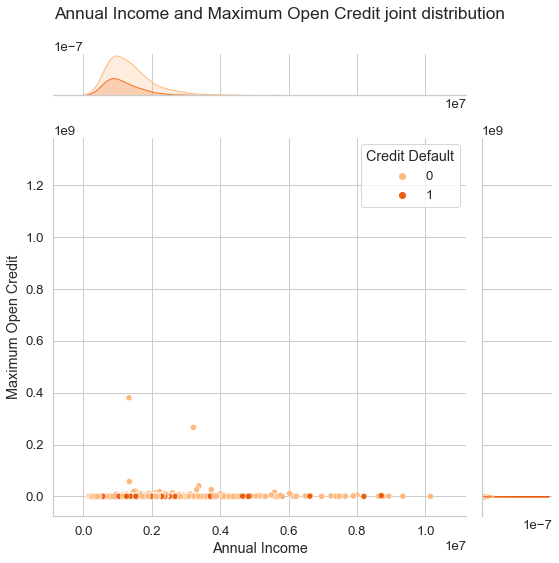

In [108]:
p = sns.jointplot(x='Annual Income', y='Maximum Open Credit', hue='Credit Default', palette='Oranges',
              height=8, data=df)
p.fig.suptitle('Annual Income and Maximum Open Credit joint distribution')
p.fig.tight_layout()
plt.show()

Похоже выбросы касаются только наблюдений, для которых погашение произошло вовремя, без просрочки. Распределение значений признака в случаях дефолтов также имеет тяжелый правый хвост, но настолько больших выбросов нет.

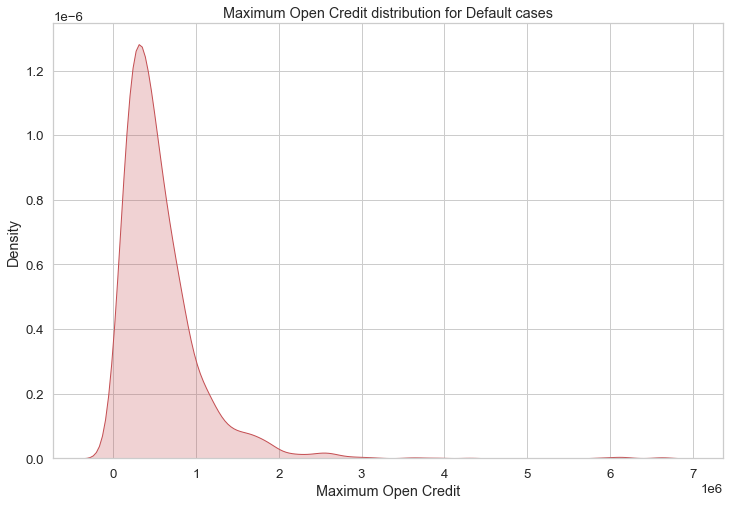

In [109]:
plt.figure(figsize=(12,8))
sns.kdeplot(df.loc[df['Credit Default'] == 1, 'Maximum Open Credit'], shade=True, color='r')
plt.title('Maximum Open Credit distribution for Default cases')
plt.show()

Таким образом с одной стороны присутствуют наблюдения, значения которых сильно отличаются от основной массы. С другой они строго относятся к одному классу целевой переменной, то есть могут быть очень полезны в задаче классификации. Для того чтобы решить, как поступать с этими наблюдениями (оставлять, удалять, заменять значения) было бы неплохо представлять каким образом собирались данные, какие существуют ограничения параметра, что именно подразумевается под определением "наибольший открытый кредит", имеются в виду все кредиты, кредитные линии в том числе.

#### Months since last delinquent

In [110]:
df['Months since last delinquent'].isna().value_counts()

True     4081
False    3419
Name: Months since last delinquent, dtype: int64

Прежде всего стоит заметить, что больше половины наблюдений имеет пропуски для данного признака.

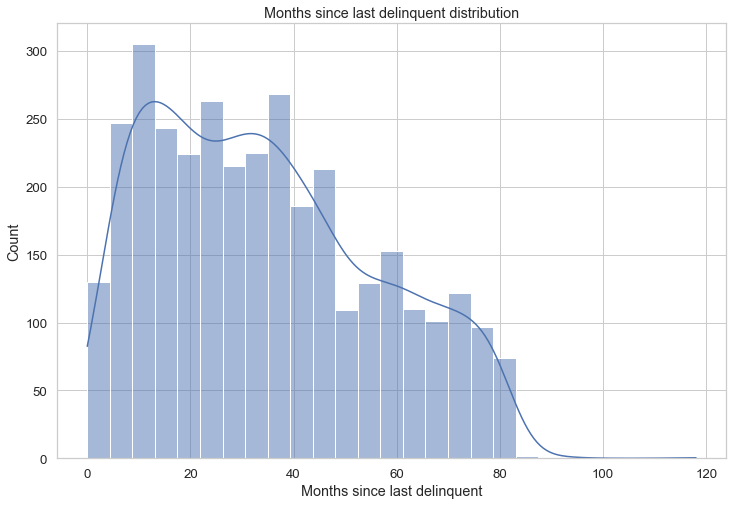

In [111]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.histplot(df['Months since last delinquent'], kde=True)
plt.title('Months since last delinquent distribution')
plt.show()

Посмотрим распредление признака в разрезе целевой переменной.

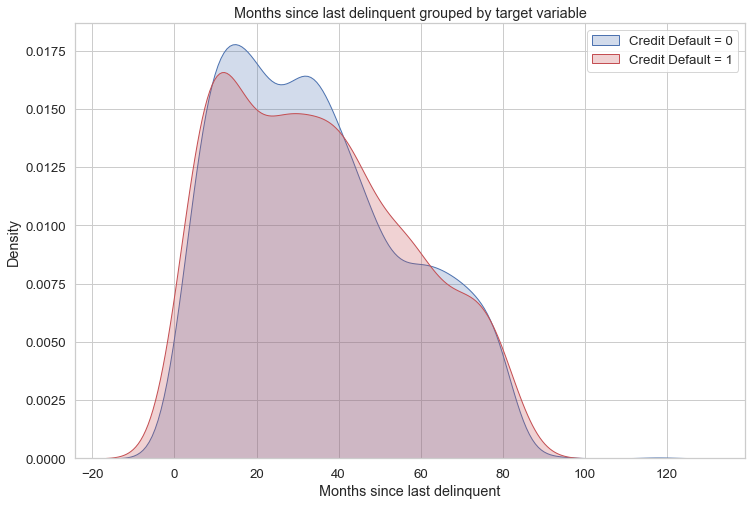

In [112]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(df.loc[df['Credit Default']==0, 'Months since last delinquent'], shade=True, 
            label='Credit Default = 0')
sns.kdeplot(df.loc[df['Credit Default']==1, 'Months since last delinquent'], shade=True, 
            label='Credit Default = 1', color='r')
plt.title('Months since last delinquent grouped by target variable')
plt.legend()
plt.show()

Так как данный признак связан с финансовой несостоятельностью, посмотрим на его форму распределения в разрезе **Bankruptcies**. Однако, как было указано выше подавляющее число наблюдений имеет значение **Bankruptcies** равное _0_ или _1_. Поэтому рассмотрим распределения анализируемого признака для нулевых и ненулевых значений показателя **Bankruptcies**.

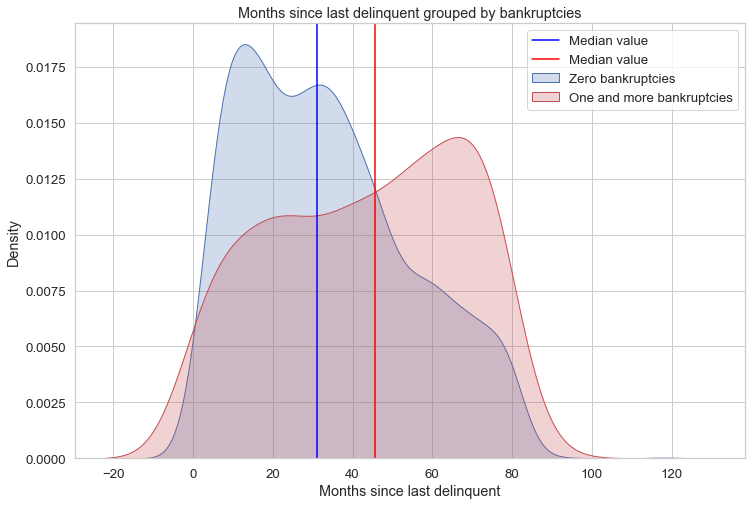

In [113]:
plt.figure(figsize=(12,8))
sns.kdeplot(df.loc[df['Bankruptcies']==0, 'Months since last delinquent'], shade=True, 
            label='Zero bankruptcies')
plt.axvline(df.loc[df['Bankruptcies']==0, 'Months since last delinquent'].median(), color='blue', 
            label='Median value')
sns.kdeplot(df.loc[df['Bankruptcies']!=0, 'Months since last delinquent'], shade=True, 
            label='One and more bankruptcies', color='r')
plt.axvline(df.loc[df['Bankruptcies']!=0, 'Months since last delinquent'].median(), color='red', 
            label='Median value')
plt.title('Months since last delinquent grouped by bankruptcies')
plt.legend()
plt.show()

Различие распределений видно невооруженным глазом. Будем заменять пропуски, исходя из медианного значения для группы, к которой относится соответствующее наблюдение.

#### Current Loan Amount

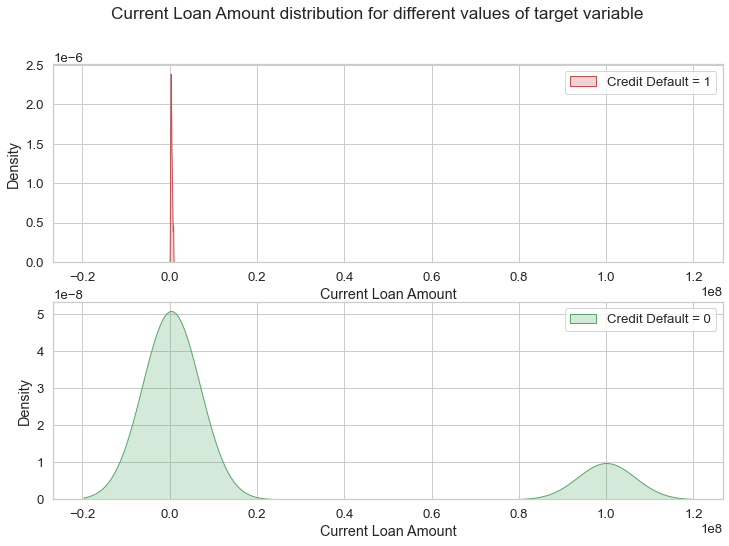

In [114]:
fig = plt.figure(figsize=(12, 8))
fig.suptitle('Current Loan Amount distribution for different values of target variable')
ax1=plt.subplot(211)
sns.kdeplot(x='Current Loan Amount', data=df[df['Credit Default']==1], shade=True, color='r', 
            label='Credit Default = 1')
plt.legend()
ax2=plt.subplot(212, sharex=ax1)
sns.kdeplot(x='Current Loan Amount', data=df[df['Credit Default']==0], shade=True, color='g', 
            label='Credit Default = 0')
plt.legend()
plt.show()

Снова можно заметить выбросы, которые характерны только для одного класса целевой переменной. Снова не до конца понятен смысл данной переменной, и почему для одного класса наблюдаются такие большие и самое главное одинаковые значения текущей суммы кредита.

In [115]:
df['Current Loan Amount'].value_counts()

99999999.0    870
89298.0         6
218064.0        6
216106.0        5
270226.0        5
             ... 
490006.0        1
404756.0        1
194414.0        1
420376.0        1
33792.0         1
Name: Current Loan Amount, Length: 5386, dtype: int64

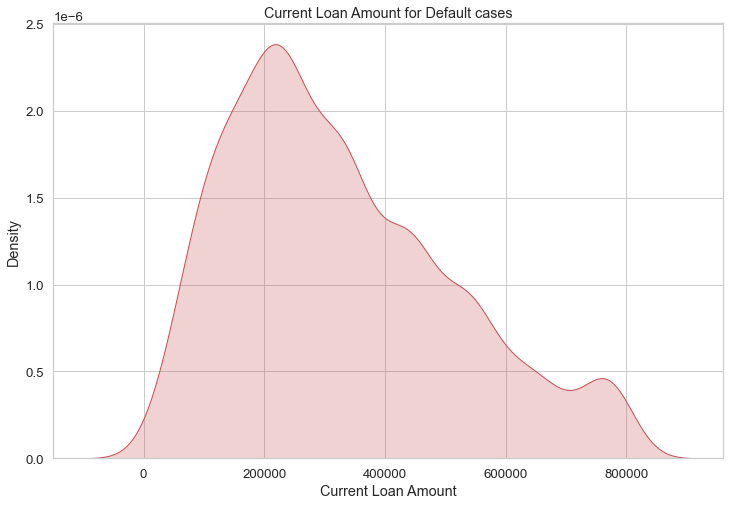

In [116]:
plt.figure(figsize=(12, 8))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(x='Current Loan Amount', data=df[df['Credit Default']==1], shade=True, color='r')
plt.title('Current Loan Amount for Default cases')
plt.show()

#### Current Credit Balance

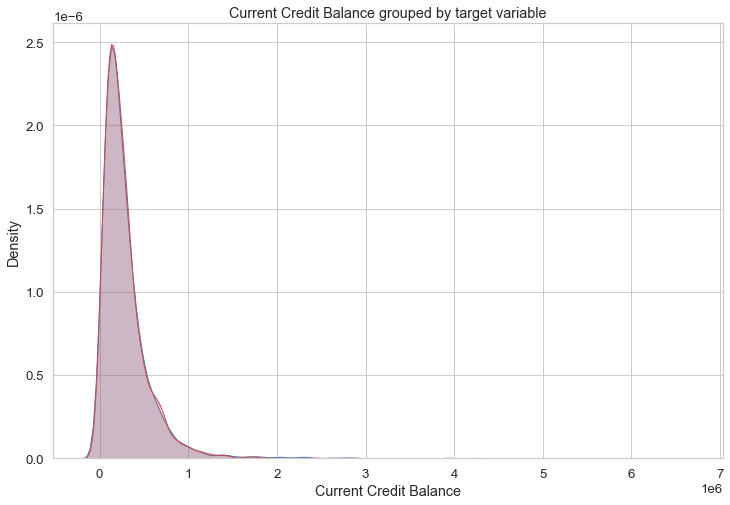

In [117]:
plt.figure(figsize=(12, 8))
sns.kdeplot(df.loc[df['Credit Default'] == 0, 'Current Credit Balance'], shade='True', 
            label='Credit Default = 0')
sns.kdeplot(df.loc[df['Credit Default'] == 1, 'Current Credit Balance'], shade='True', 
            color='r', label='Credit Default = 1')
plt.title('Current Credit Balance grouped by target variable')
plt.show()

Судя по графику распределения в разрезе целевой переменной очень похожи.

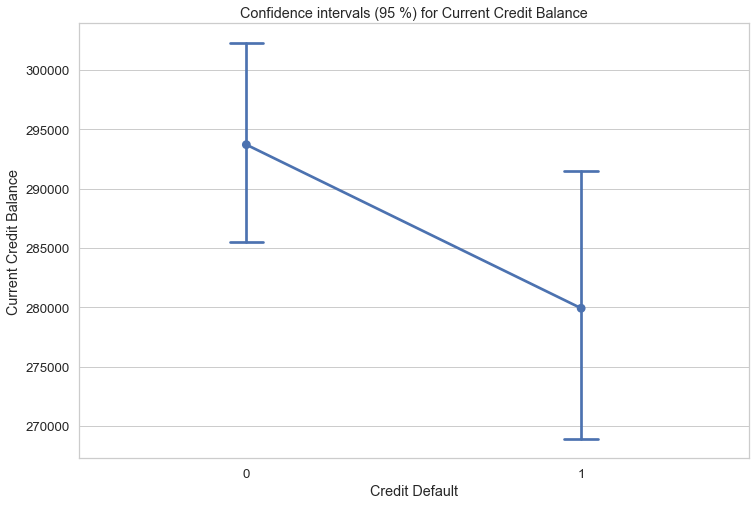

In [118]:
plt.figure(figsize=(12, 8))
sns.pointplot(x='Credit Default', y='Current Credit Balance', data=df, capsize=.1)
plt.title('Confidence intervals (95 %) for Current Credit Balance')
plt.show()

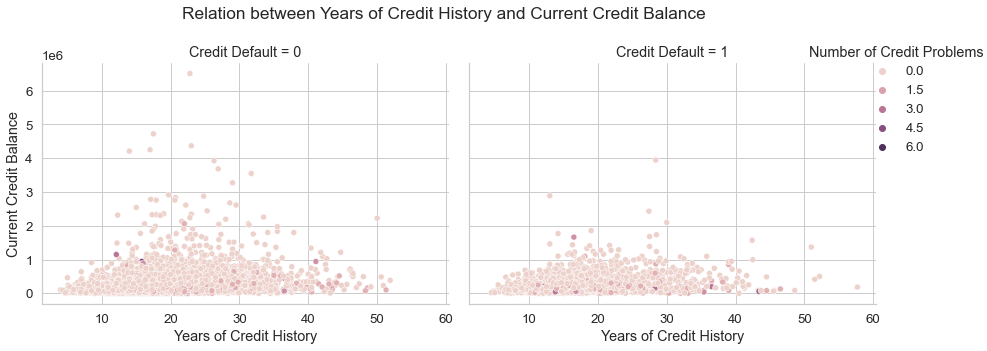

In [119]:
p = sns.relplot(x='Years of Credit History', y='Current Credit Balance', hue='Number of Credit Problems',
            col='Credit Default', height=5, data=df)
p.fig.suptitle('Relation between Years of Credit History and Current Credit Balance')
p._legend.set_bbox_to_anchor([1.1,0.7])
p.fig.tight_layout()
plt.show()

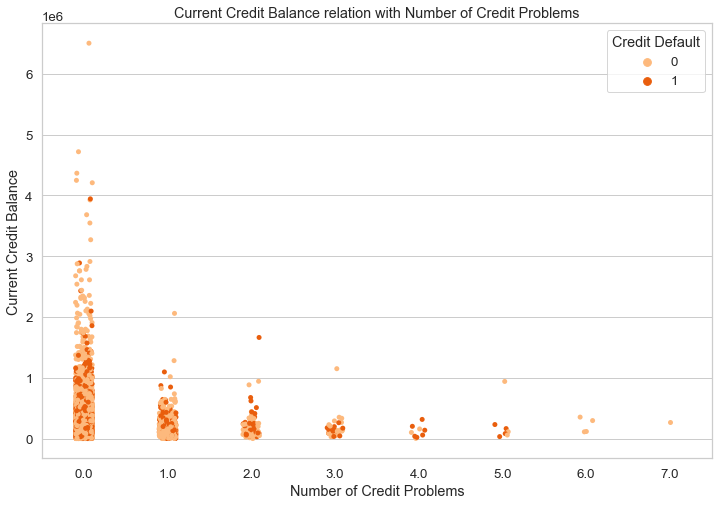

In [120]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='Number of Credit Problems', y='Current Credit Balance', hue='Credit Default', 
              palette='Oranges', data=df)
plt.title('Current Credit Balance relation with Number of Credit Problems')
plt.show()

Можно отметить тенденцию к снижению текущего кредитного баланса с увеличением количества кредитных проблем.

#### Monthly Debt

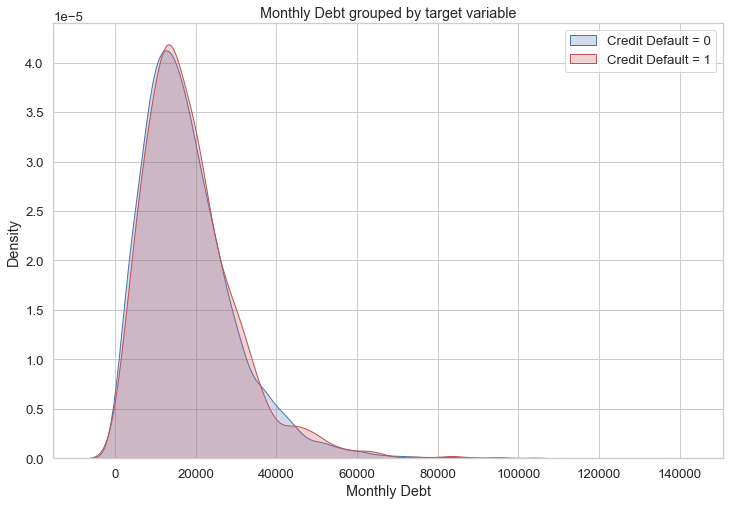

In [121]:
plt.figure(figsize=(12, 8))
sns.kdeplot(df.loc[df['Credit Default'] == 0, 'Monthly Debt'], shade=True, 
            label='Credit Default = 0')
sns.kdeplot(df.loc[df['Credit Default'] == 1, 'Monthly Debt'], shade=True, 
            color='r', label='Credit Default = 1')
plt.title('Monthly Debt grouped by target variable')
plt.legend()
plt.show()

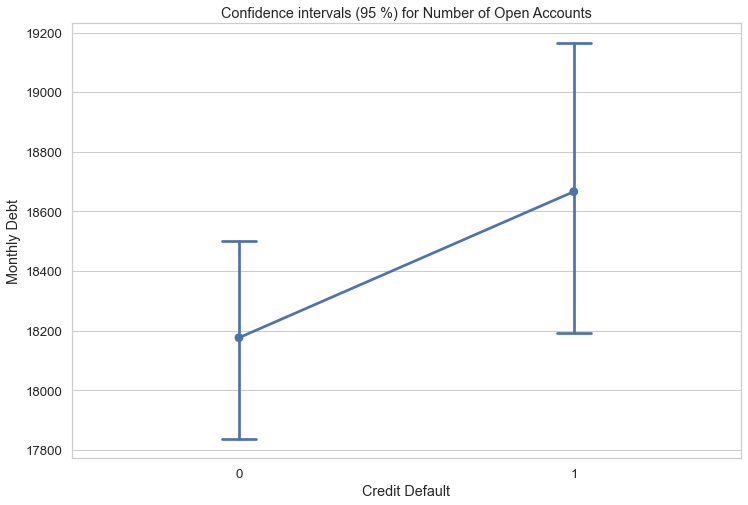

In [122]:
plt.figure(figsize=(12, 8))
sns.pointplot(x='Credit Default', y='Monthly Debt', 
              data=df, capsize=.1)
plt.title('Confidence intervals (95 %) for Number of Open Accounts')
plt.show()

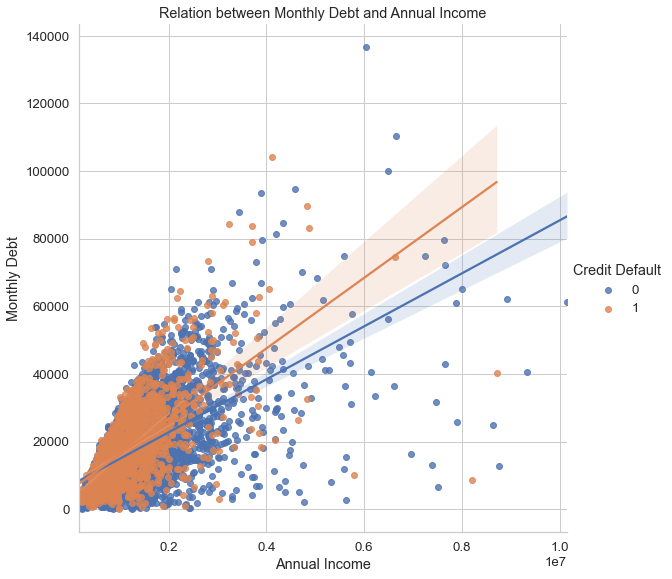

In [123]:
sns.lmplot(x='Annual Income', y='Monthly Debt', hue='Credit Default', height=8, data=df)
plt.title('Relation between Monthly Debt and Annual Income')
plt.show()

Похоже для индивидов, допускающих просрочку по кредитам, величина ежемесячного долга выше при сопоставимом уровне дохода, чем для индивидов, платящих вовремя. Используем это наблюдение для построения новой переменной равной отношению **Montly Debt** к величине **Annual Income**.

#### Credit Score

In [124]:
df['Credit Score'].describe()

count    5943.000000
mean     1151.087498
std      1604.451418
min       585.000000
25%       711.000000
50%       731.000000
75%       743.000000
max      7510.000000
Name: Credit Score, dtype: float64

Снова явно видно наличие выбросов. В задании явно не указана страна, для которой проводится исследование, однако значения больше 1000 выглядят странными.

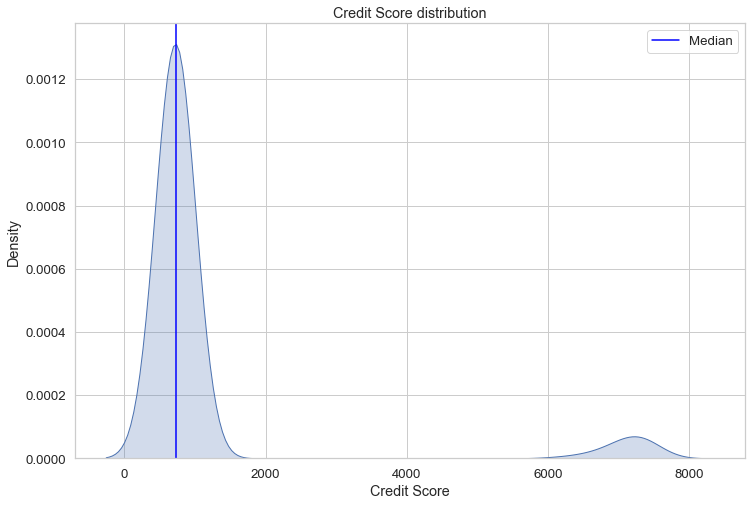

In [125]:
plt.figure(figsize=(12,8))
plt.ticklabel_format(style='plain', axis='x')
sns.kdeplot(df['Credit Score'], shade=True)
plt.axvline(df['Credit Score'].median(), color='blue', label='Median')
plt.title('Credit Score distribution')
plt.legend()
plt.show()

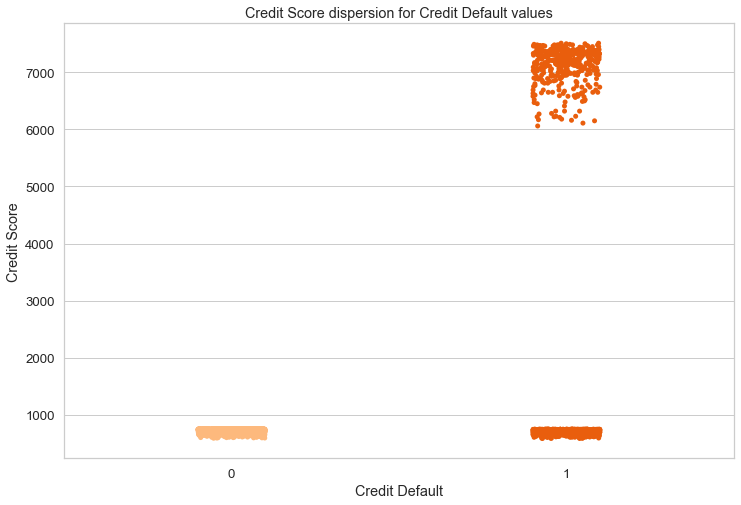

In [126]:
plt.figure(figsize=(12, 8))
sns.stripplot(x='Credit Default', y='Credit Score', palette='Oranges', data=df)
plt.title('Credit Score dispersion for Credit Default values')
plt.show()

Однако видно, что эти выбросы целиком относятся к одному классу целевой переменной, а значит это может быть использовано при анализе.

## Полезные функции для обработки данных <a class="anchor" id="functions"></a>

Создадим классы для предварительной обработки данных и создания новых признаков:

In [127]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.median_bankr0 = None
        self.median_bankr1 = None
        self.years_in_current_job_freq_value = None
        
    def fit(self, X):
        """Сохранение статистик"""
        self.medians = X.median()
        self.median_bankr0 = X.loc[X['Bankruptcies']==0, 'Months since last delinquent'].median()
        self.median_bankr1 = X.loc[X['Bankruptcies']!=0, 'Months since last delinquent'].median()
        self.years_in_current_job_freq_value = X['Years in current job'].value_counts().index[0]
    
    def transform(self, X):
        """Трансформация данных"""
        
        
        # Добавим дамми столбцы, чтобы выделить наблюдения, в которых мы заменили пропущенные значения
        condition_annual_income = X['Annual Income'].isna()
        X['Annual Income Missing Value'] = 0
        X.loc[condition_annual_income, 'Annual Income Missing Value'] = 1
        
        condition_years_in_current_job = X['Years in current job'].isna()
        X['Years in current job Missing Value'] = 0
        X.loc[condition_years_in_current_job, 'Years in current job Missing Value'] = 1
        
        condition_credit_score = X['Credit Score'].isna()
        X['Credit Score Missing Value'] = 0
        X.loc[condition_credit_score, 'Credit Score Missing Value'] = 1
        
        condition_months_delinquent = X['Months since last delinquent'].isna()
        X['Months since last delinquent Missing Value'] = 0
        X.loc[condition_months_delinquent, 'Months since last delinquent Missing Value'] = 1
        
        
        # Years in current job
        X.loc[condition_years_in_current_job, 'Years in current job'] = self.years_in_current_job_freq_value
        
        # Months since last delinquent
        condition_bankruptcy = X['Bankruptcies']==0
        X.loc[(condition_bankruptcy) & (condition_months_delinquent), 
              'Months since last delinquent'] = self.median_bankr0
        X.loc[(~condition_bankruptcy) & (condition_months_delinquent),
              'Months since last delinquent'] = self.median_bankr1
        
        
        # Заменяем пропущенные значения медианным для соответствующего признака
        X.fillna(self.medians, inplace=True)
        
        X['Tax Liens'] = X['Tax Liens'].astype('int64')
        X['Number of Credit Problems'] = X['Number of Credit Problems'].astype('int64')
        X['Bankruptcies'] = X['Bankruptcies'].astype('int64')
        
        return X

In [128]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def transform(self, X):
        
        # Monthly Debt per Annual Income
        X['Monthly Debt per Annual Income'] = X['Monthly Debt'] / X['Annual Income']
        
        return X

Функция для балансировки данных:

In [129]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

Функция для представления результатов модели:

In [130]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

Функция для наглядного ранжирования важных признаков:

In [131]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'], palette='Oranges')
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

## Подготовка данных для анализа <a class="anchor" id="preparation"></a>

In [132]:
TARGET_NAME = 'Credit Default'
NUM_FEATURE_NAMES = ['Annual Income', 'Number of Open Accounts', 'Years of Credit History', 'Maximum Open Credit',
                    'Months since last delinquent', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                     'Credit Score', 'Monthly Debt per Annual Income']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Tax Liens', 'Number of Credit Problems', 
                     'Bankruptcies', 'Purpose', 'Term']
NEW_POSSIBLE_CAT_FEATURE_NAMES = ['Annual Income Missing Value', 'Years in current job Missing Value', 
                             'Credit Score Missing Value', 'Months since last delinquent Missing Value']

In [133]:
y = df[TARGET_NAME]
X = df.drop(columns=[TARGET_NAME])

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=0)

In [135]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

Балансировка данных:

In [136]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3818
1    2864
Name: Credit Default, dtype: int64

In [137]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

In [138]:
preprocessor.transform(X_train)
preprocessor.transform(X_test)

feature_generator = FeatureGenetator()
feature_generator.transform(X_train)
feature_generator.transform(X_test)

X_test.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Annual Income Missing Value,Years in current job Missing Value,Credit Score Missing Value,Months since last delinquent Missing Value,Monthly Debt per Annual Income
1563,Rent,1412327.0,2 years,0,19.0,17.9,1270588.0,1,32.0,1,...,Short Term,99999999.0,389557.0,31424.0,738.0,0,0,0,0,0.022250
5333,Home Mortgage,1267395.0,3 years,0,11.0,11.8,137676.0,1,61.0,0,...,Short Term,99999999.0,34124.0,25559.0,719.0,0,0,0,0,0.020167
7424,Home Mortgage,3069488.0,7 years,0,10.0,16.4,911064.0,0,31.0,0,...,Short Term,646206.0,738834.0,50902.0,714.0,0,0,0,0,0.016583
6731,Rent,1339139.0,8 years,0,28.0,29.5,937904.0,0,31.0,0,...,Long Term,435556.0,421211.0,18971.0,663.0,0,0,0,1,0.014167
4178,Home Mortgage,1193903.0,3 years,0,12.0,19.5,1113222.0,0,31.0,0,...,Short Term,239712.0,460522.0,31165.0,732.0,1,0,1,1,0.026103


In [139]:
for colname in CAT_FEATURE_NAMES:
    X_train[colname] = pd.Categorical(X_train[colname])
    X_test[colname] = pd.Categorical(X_test[colname])
    
X_train[CAT_FEATURE_NAMES].dtypes

Home Ownership               category
Years in current job         category
Tax Liens                    category
Number of Credit Problems    category
Bankruptcies                 category
Purpose                      category
Term                         category
dtype: object

In [140]:
X_train = X_train.drop(columns=NEW_POSSIBLE_CAT_FEATURE_NAMES + 
                       ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems'])
X_test = X_test.drop(columns=NEW_POSSIBLE_CAT_FEATURE_NAMES + 
                     ['Tax Liens', 'Bankruptcies',  'Number of Credit Problems'])
CAT_FEATURE_NAMES = ['Home Ownership', 'Term',  'Years in current job', 'Purpose']

## Построение модели <a class="anchor" id="model"></a>

Итоговая модель:

In [141]:
final_model = catb.CatBoostClassifier(n_estimators=700, max_depth=3,
                                      l2_leaf_reg=13,
                                      silent=True, random_state=0, cat_features=CAT_FEATURE_NAMES)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.87      0.81      3818
           1       0.78      0.60      0.68      2864

    accuracy                           0.76      6682
   macro avg       0.76      0.74      0.74      6682
weighted avg       0.76      0.76      0.75      6682

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1569
           1       0.58      0.52      0.55       681

    accuracy                           0.74      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.73      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1309  260
1                327  354


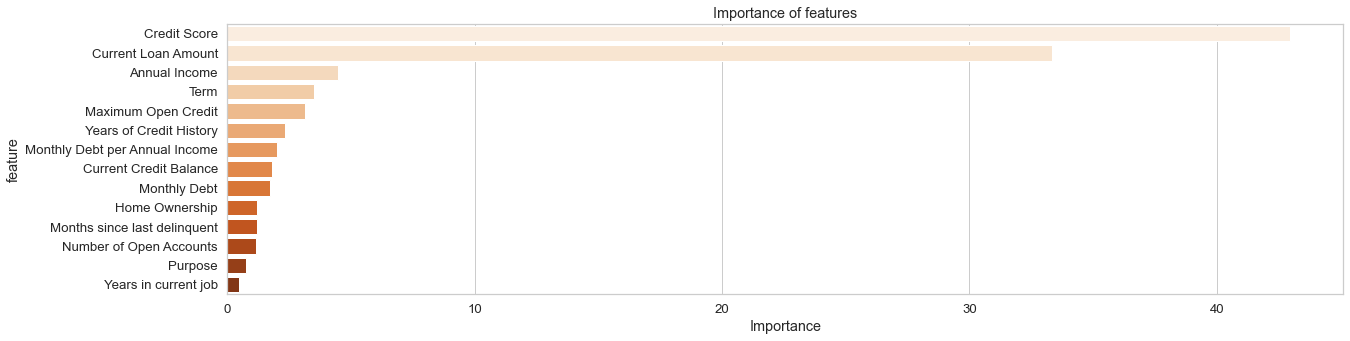

In [142]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_)

## Сохранение результатов <a class="anchor" id="results"></a>

In [143]:
X_test_data = pd.read_csv(TEST_PATH)
X_test_data.shape

(2500, 16)

In [144]:
preprocessor.transform(X_test_data)
feature_generator.transform(X_test_data)
X_test_data = X_test_data.drop(columns=NEW_POSSIBLE_CAT_FEATURE_NAMES + 
                     ['Tax Liens', 'Bankruptcies',  'Number of Credit Problems'])

In [145]:
y_test_data_pred = final_model.predict(X_test_data)

In [146]:
pd.DataFrame(y_test_data_pred).to_csv('RKosmodemianskii_predictions.csv', index=False)